___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright Pierian Data</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# RNN Example for Time Series

In [4]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [97]:
df = pd.read_csv('../Data/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [33]:
df = pd.read_csv("s3://xspdev-data-experiments/hluan/CDP_EDA_DATA/201705_201905_groupby_summary.csv", ,index_col=0,parse_dates=True)

In [6]:
df.head()

,total_number_accts,B,1,2,3,4,5,I
2019-04-01,1939994,37.410903,22.797874,17.828636,14.560897,13.636172,12.472325,0.844135
2019-03-01,1939994,40.235656,27.557480,20.231416,20.411935,15.538052,13.196986,0.757253
2019-02-01,1939994,32.704472,17.540795,15.130603,11.870755,10.495215,8.928977,0.632409
2019-01-01,1939994,30.348857,20.961053,15.403464,13.491137,12.005191,9.321411,0.701568
2018-12-01,1939994,39.882388,27.594751,21.482483,16.452582,15.600124,14.174852,1.248435


In [99]:
df.columns = ['Sales']

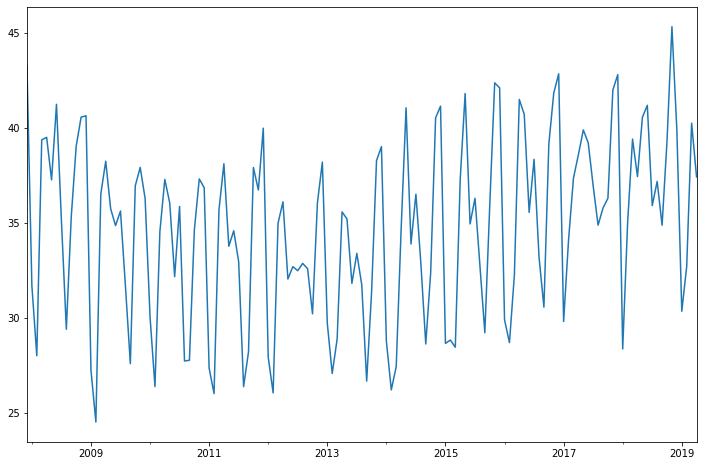

In [14]:
df.plot(figsize=(12,8))

## Train Test Split

In [34]:
df = df[['B']]

In [35]:
df = df.sort_index()

In [36]:
len(df)

137

Data is monthly, let's forecast 1.5 years into the future.

In [37]:
len(df)- 18

119

In [124]:
test_size = 15

In [125]:
test_ind = len(df)- test_size

In [126]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [127]:
train

,B
2007-12-01,43.243739
2008-01-01,31.695096
2008-02-01,28.012559
2008-03-01,39.361627
2008-04-01,39.493228
2008-05-01,37.257755
2008-06-01,41.228214
2008-07-01,35.131966
2008-08-01,29.404100
2008-09-01,35.320911


In [128]:
test

,B
2018-02-01,34.996006
2018-03-01,39.401301
2018-04-01,37.431021
2018-05-01,40.542821
2018-06-01,41.175338
2018-07-01,35.904334
2018-08-01,37.174560
2018-09-01,34.872876
2018-10-01,39.294741
2018-11-01,45.308082


## Scale Data

In [129]:
from sklearn.preprocessing import MinMaxScaler

In [130]:
scaler = MinMaxScaler()

In [131]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [132]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [133]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [134]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [135]:
# What does the first batch look like?
X,y = generator[0]

In [136]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[1.         0.38295408 0.18619557 0.79257812 0.79960956 0.68016789
 0.89231013 0.56658665 0.26054583 0.57668199 0.77456927 0.85631068]
Predict this y: 
 [[0.85997165]]


### Create the Model

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [138]:
# We're only using one feature in our time series
n_features = 1

In [247]:
# define model
model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [248]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 300)               362400    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [249]:
from tensorflow.keras.callbacks import EarlyStopping

In [250]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [251]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [252]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
110/110 [==============================] - 4s 38ms/step - loss: 0.0875 - val_loss: 0.0504
Epoch 2/20
110/110 [==============================] - 4s 36ms/step - loss: 0.0566 - val_loss: 0.0293
Epoch 3/20
110/110 [==============================] - 4s 37ms/step - loss: 0.0547 - val_loss: 0.0300
Epoch 4/20
110/110 [==============================] - 4s 36ms/step - loss: 0.0349 - val_loss: 0.0121
Epoch 5/20
110/110 [==============================] - 4s 37ms/step - loss: 0.0289 - val_loss: 0.0140
Epoch 6/20
110/110 [==============================] - 4s 38ms/step - loss: 0.0273 - val_loss: 0.0120
Epoch 7/20
110/110 [==============================] - 4s 37ms/step - loss: 0.0260 - val_loss: 0.0232
Epoch 8/20
110/110 [==============================] - 4s 37ms/step - loss: 0.0266 - val_loss: 0.0201


In [253]:
losses = pd.DataFrame(model.history.history)

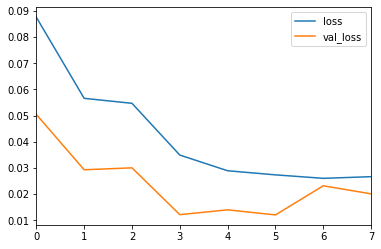

In [254]:
losses.plot()

## Evaluate on Test Data

In [255]:
first_eval_batch = scaled_train[-length:]

In [256]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [257]:
model.predict(first_eval_batch)

array([[0.5902287]], dtype=float32)

In [258]:
scaled_test[0]

array([0.55932229])

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [259]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

In [260]:
true_predictions = scaler.inverse_transform(test_predictions)

In [261]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [262]:
test

,B,Predictions
2018-02-01,34.996006,35.574451
2018-03-01,39.401301,38.082394
2018-04-01,37.431021,39.313016
2018-05-01,40.542821,40.030465
2018-06-01,41.175338,38.963862
2018-07-01,35.904334,36.966951
2018-08-01,37.174560,35.873516
2018-09-01,34.872876,36.570527
2018-10-01,39.294741,38.627915
2018-11-01,45.308082,42.675597


In [275]:
test.Predictions.values

array([35.57445102, 38.0823944 , 39.31301627, 40.03046525, 38.96386219,
       36.96695093, 35.87351638, 36.57052715, 38.62791524, 42.67559706,
       40.53498696, 31.22390478, 36.88857826, 38.93262757, 40.00637134])

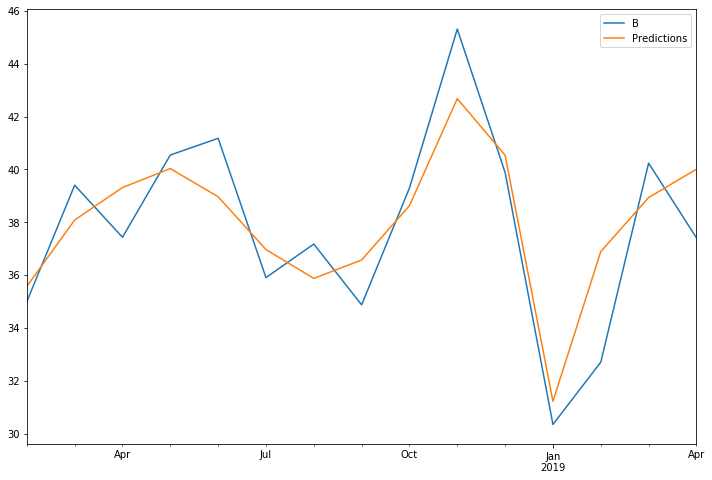

In [263]:
test.plot(figsize=(12,8))

# Retrain and Forecasting

In [133]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [134]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [135]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 11s 33ms/step - loss: 0.0242
Epoch 2/8
322/322 [==============================] - 11s 33ms/step - loss: 0.0151
Epoch 3/8
322/322 [==============================] - 11s 35ms/step - loss: 0.0087
Epoch 4/8
322/322 [==============================] - 11s 33ms/step - loss: 0.0047
Epoch 5/8
322/322 [==============================] - 11s 33ms/step - loss: 0.0036
Epoch 6/8
322/322 [==============================] - 11s 35ms/step - loss: 0.0020
Epoch 7/8
322/322 [==============================] - 11s 34ms/step - loss: 0.0019
Epoch 8/8
322/322 [==============================] - 11s 34ms/step - loss: 0.0013


In [140]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [141]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [142]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [143]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [148]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [149]:
forecast_df

,Forecast
2019-11-01,25409.321535
2019-12-01,35249.757977
2020-01-01,16736.460991
2020-02-01,18504.182830
2020-03-01,21799.887453
2020-04-01,21491.501070
2020-05-01,22937.753417
2020-06-01,21190.737333
2020-07-01,21729.576211
2020-08-01,23488.765873


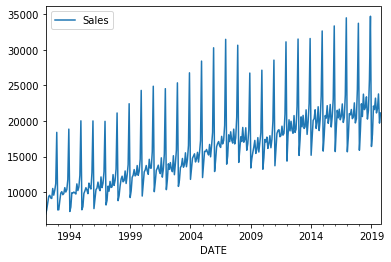

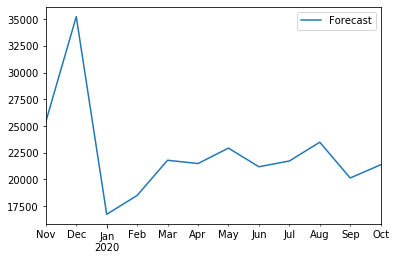

In [150]:
df.plot()
forecast_df.plot()

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

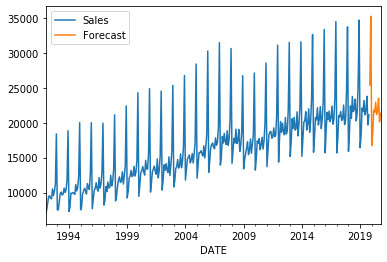

In [151]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576, 611)

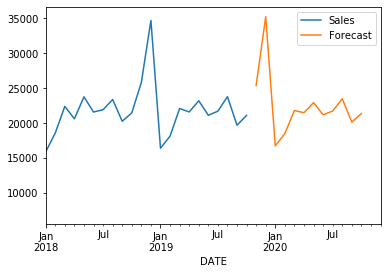

In [153]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')

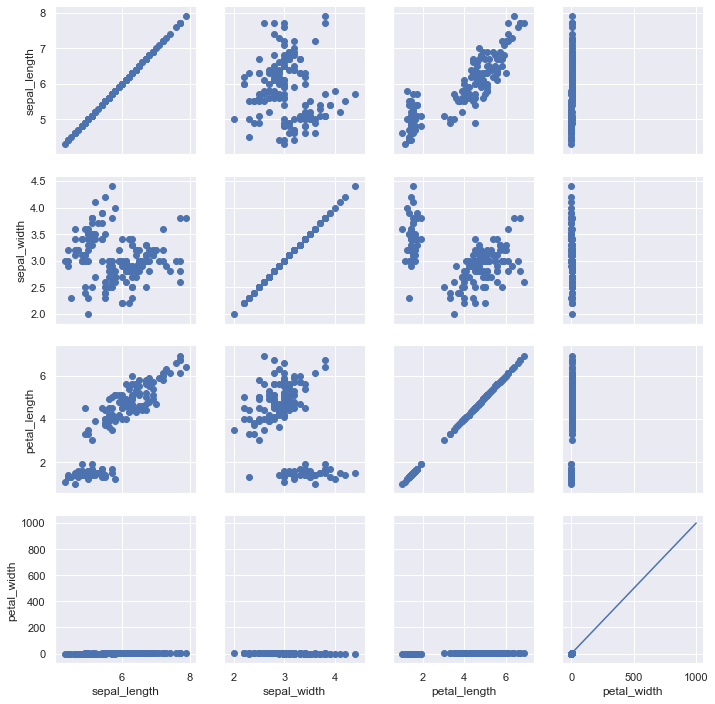

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
iris = sns.load_dataset("iris")
g = sns.PairGrid(iris)
g = g.map(two_plot(plt.scatter))

# Great Job!

In [269]:
def two_plot(func):
    plt.plot(range(1000))
    return func

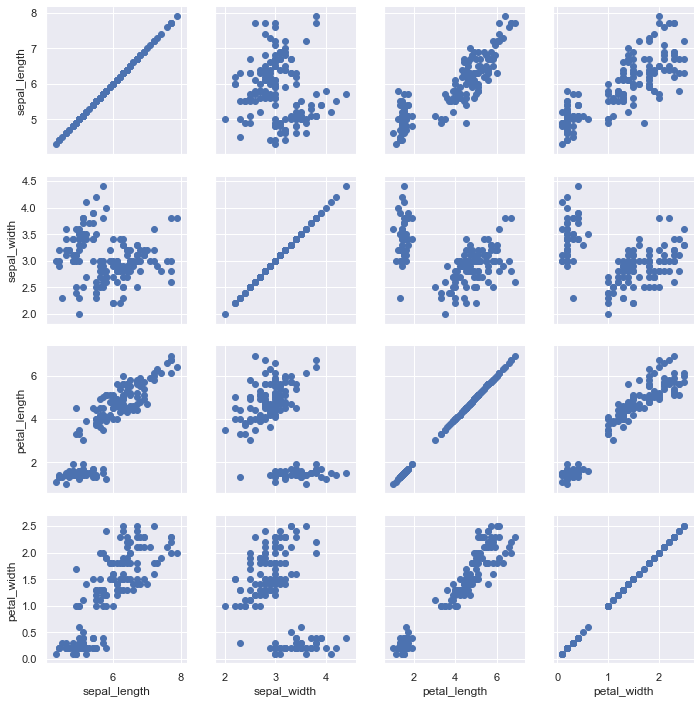

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
iris = sns.load_dataset("iris")
g = sns.PairGrid(iris)
g = g.map(plt.scatter)